In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from pylab import rcParams

https://www.bls.gov/oes/current/naics3_334000.htm

https://fred.stlouisfed.org/series/PCU334334

In [2]:
df = pd.read_csv('RawData/334000 - Computer and Electronic Product Manufacturing.csv')

In [3]:
df.head()

,DATE,PCU334334
0,2003-12-01,100.0
1,2004-01-01,99.8
2,2004-02-01,99.5
3,2004-03-01,99.3
4,2004-04-01,99.5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   DATE       234 non-null    object 
 1   PCU334334  234 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.8+ KB


In [5]:
df['Price'] = df['PCU334334']
df_new = df.drop(['PCU334334'],axis=1)
df_new['Date']= pd.to_datetime(df_new['DATE'])
df_new =  df_new.set_index(df_new['Date'])
df_new.drop(['Date','DATE'], axis=1 , inplace=True)
df_new.head()

,Price
Date,
2003-12-01,100.0
2004-01-01,99.8
2004-02-01,99.5
2004-03-01,99.3
2004-04-01,99.5


<Axes: xlabel='Date'>

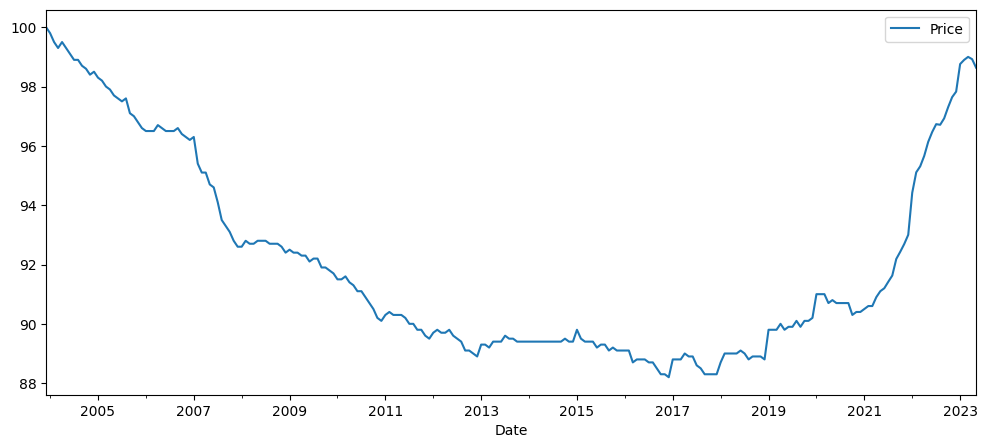

In [6]:
df_new.plot(figsize=(12,5))

## Data Cleaning

In [7]:
df_new.isnull().sum()

Price    0
dtype: int64

In [8]:
# df.dropna(inplace = True)
# df.reset_index(drop=False,inplace=True)

In [9]:
df_new.shape

(234, 1)

In [10]:
df_new = df_new.sort_values('Date', ascending=True)
df_new.index.freq = 'MS'

In [11]:
df_new.head()

,Price
Date,
2003-12-01,100.0
2004-01-01,99.8
2004-02-01,99.5
2004-03-01,99.3
2004-04-01,99.5


In [12]:
# df_new = df_new.iloc[110:]

In [13]:
df_new.shape

(234, 1)

<Axes: xlabel='Date', ylabel='Price'>

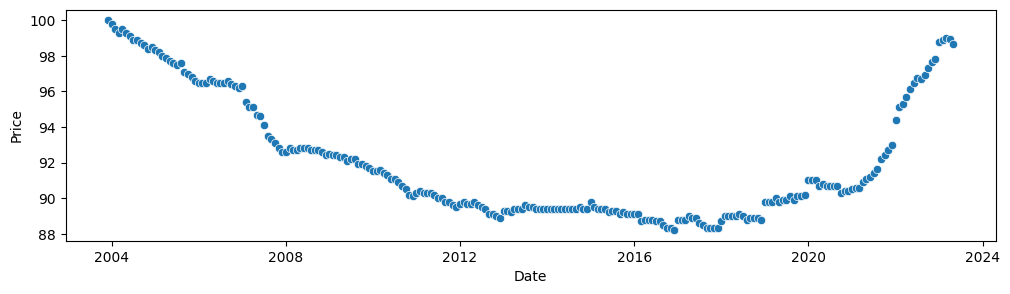

In [14]:
plt.figure(figsize=(12,3))

sns.scatterplot(x=df_new.index, y=df_new['Price'])

<Axes: >

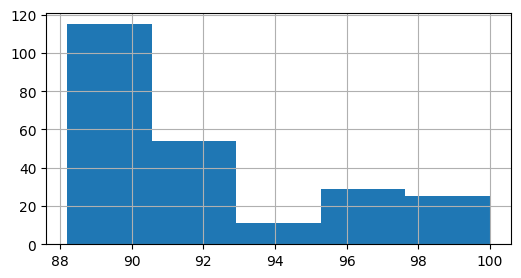

In [15]:
plt.figure(figsize=(6,3))

df_new['Price'].hist(bins=5)

<Axes: >

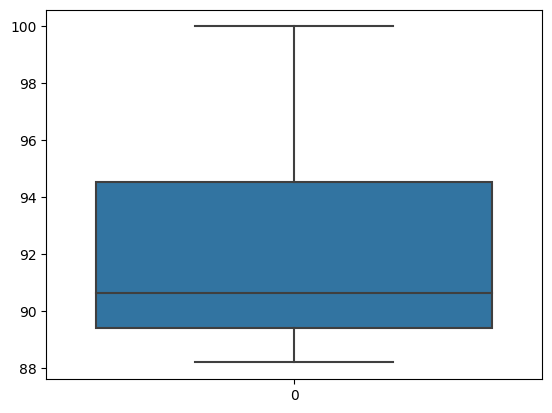

In [16]:
sns.boxplot(df_new['Price'])

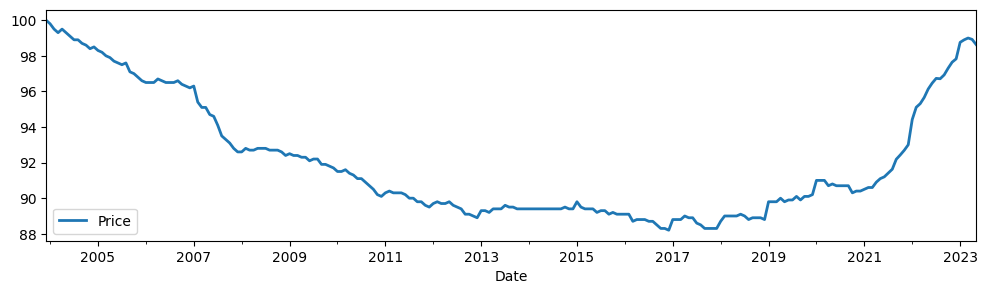

In [17]:
df_new.plot.line(y='Price',figsize=(12,3),lw=2);

<Axes: title={'center': 'Seasonality of the Time Series'}, xlabel='Month', ylabel='Price'>

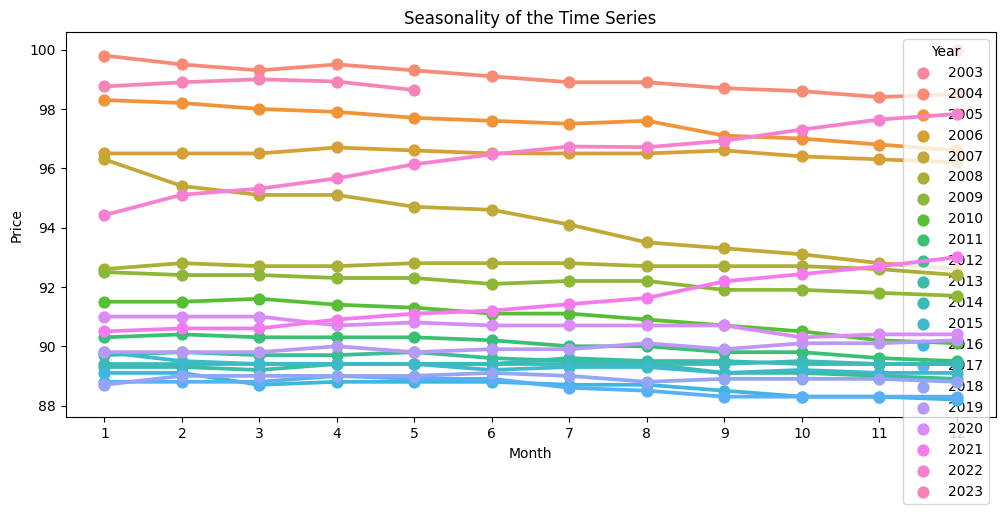

In [18]:
# To plot the seasonality we are going to create a temp dataframe and add columns for Month and Year values
df_temp = df_new.copy()
df_temp['Year'] = pd.DatetimeIndex(df_temp.index).year
df_temp['Month'] = pd.DatetimeIndex(df_temp.index).month
# Stacked line plot
plt.figure(figsize=(12,5))
plt.title('Seasonality of the Time Series')
sns.pointplot(x='Month',y='Price',hue='Year',data=df_temp)

https://www.metafab.com/steel-prices-growth-in-metal-fabrication/

In [19]:
df_pre = df_new[:'2020-03-1']
df_pandemic = df_new['2020-03-1':'2022-01-01']
df_post = df_new['2022-01-01':]

<Axes: xlabel='Date'>

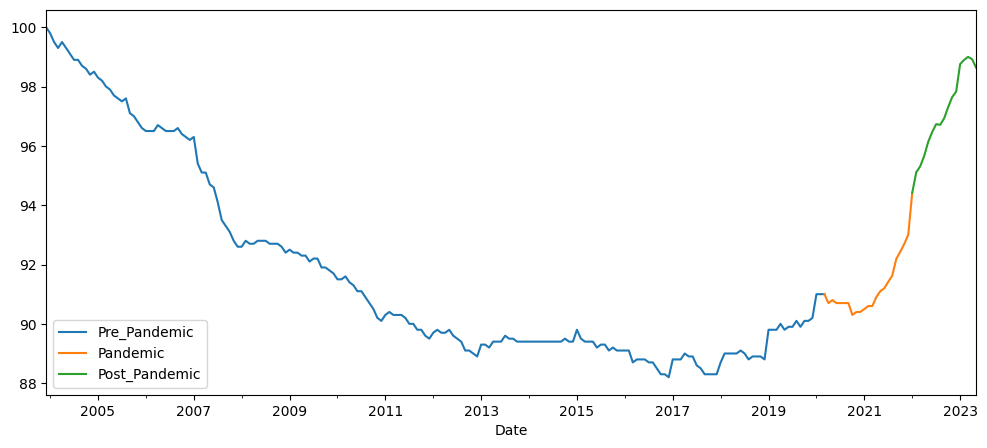

In [20]:
df_pre['Price'].plot(legend=True, label='Pre_Pandemic',figsize=(12,5))
df_pandemic['Price'].plot(legend=True, label='Pandemic')
df_post['Price'].plot(legend=True, label = 'Post_Pandemic')

## Decomposition of Time Series

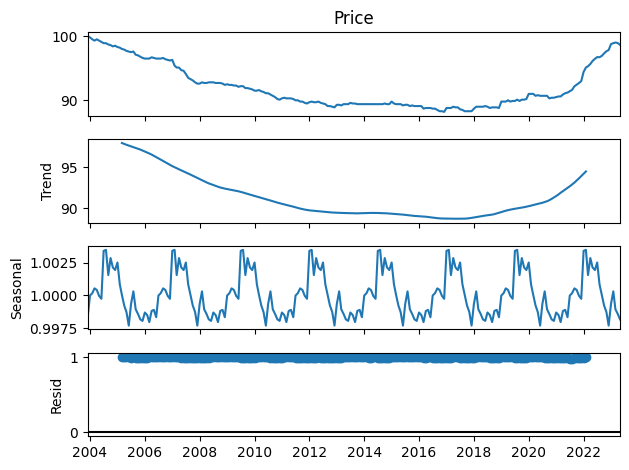

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_new['Price'], model='multiplicative',period=30)  # model='mul' also works
result.plot();

## Simple Moving Average (SMA)

In [22]:
df_new['12-month-SMA'] = df_new['Price'].rolling(window=12).mean()

<Axes: xlabel='Date'>

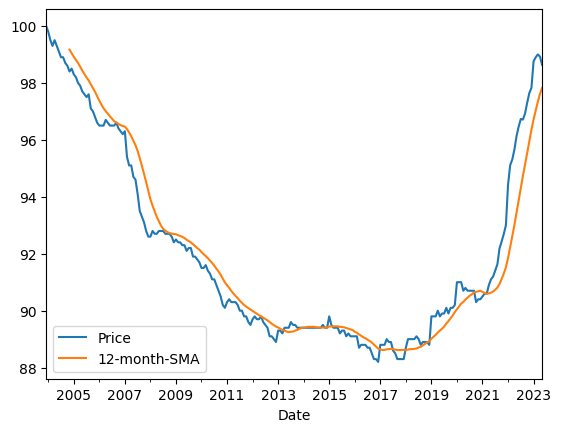

In [23]:
df_new[['Price','12-month-SMA']].plot()

## Exponentially Weighted Moving Average (EWMA)

In [24]:
df_new['EWMA12'] = df_new['Price'].ewm(span=12,adjust=False).mean()

<Axes: xlabel='Date'>

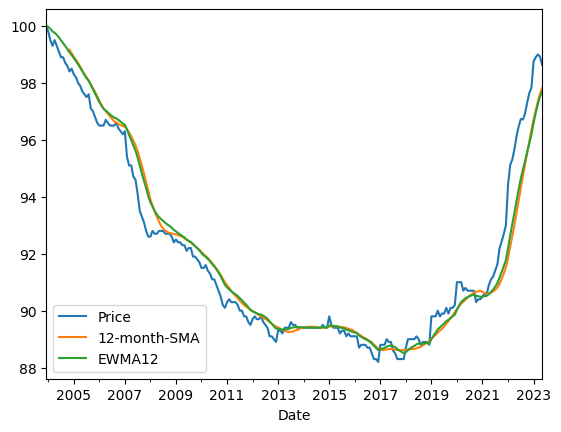

In [25]:
df_new[['Price','12-month-SMA','EWMA12']].plot()

## Comparing SMA to EWMA

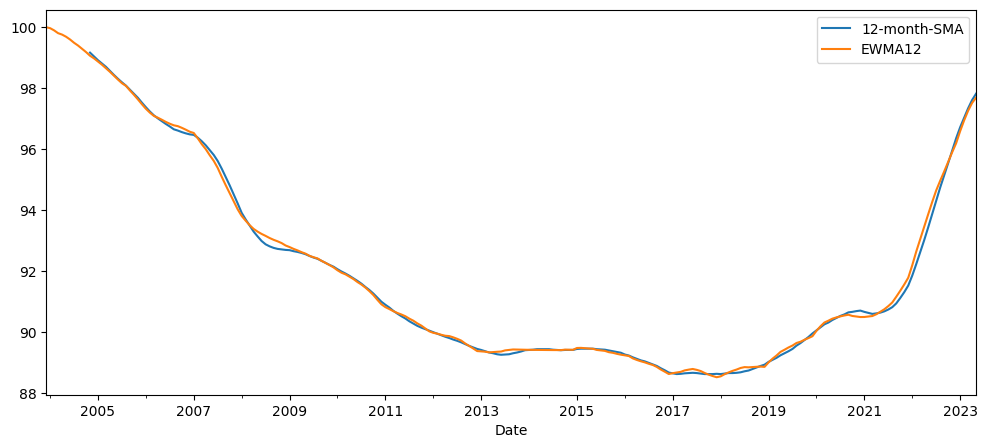

In [26]:
df_new[['12-month-SMA','EWMA12']].plot(figsize=(12,5)).autoscale(axis='x',tight=True);

https://stackoverflow.com/questions/60017052/decompose-for-time-series-valueerror-you-must-specify-a-period-or-x-must-be

## Check for Stationarity

### Augmented Dickey Fuller (ADF) Test 

#### p-value > 0.05: non-stationary.
#### p-value <= 0.05: stationary.
#### Test statistics: More negative this value more likely we have stationary series. Also, this value should be smaller than critical values(1%, 5%, 10%). For e.g. If test statistic is smaller than the 5% critical values, then we can say with 95% confidence that this is a stationary series

In [27]:
def stationarity_test(timeseries):
    # Get rolling statistics for window = 12 i.e. yearly statistics
    rolling_mean = timeseries.rolling(window = 12).mean()
    rolling_std = timeseries.rolling(window = 12).std()
    
    # Plot rolling statistic
    plt.figure(figsize= (10,6))
    plt.xlabel('Month')
    plt.ylabel('Item_Price')    
    plt.title('Stationary Test: Rolling Mean and Standard Deviation')
    plt.plot(timeseries, color= 'blue', label= 'Original')
    plt.plot(rolling_mean, color= 'green', label= 'Rolling Mean')
    plt.plot(rolling_std, color= 'red', label= 'Rolling Std')   
    plt.legend()
    plt.show()
    
    # Dickey-Fuller test
    print('Results of Dickey-Fuller Test')
    df_test = adfuller(timeseries)
    df_output = pd.Series(df_test[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in df_test[4].items():
        df_output['Critical Value (%s)' %key] = value
    print(df_output)

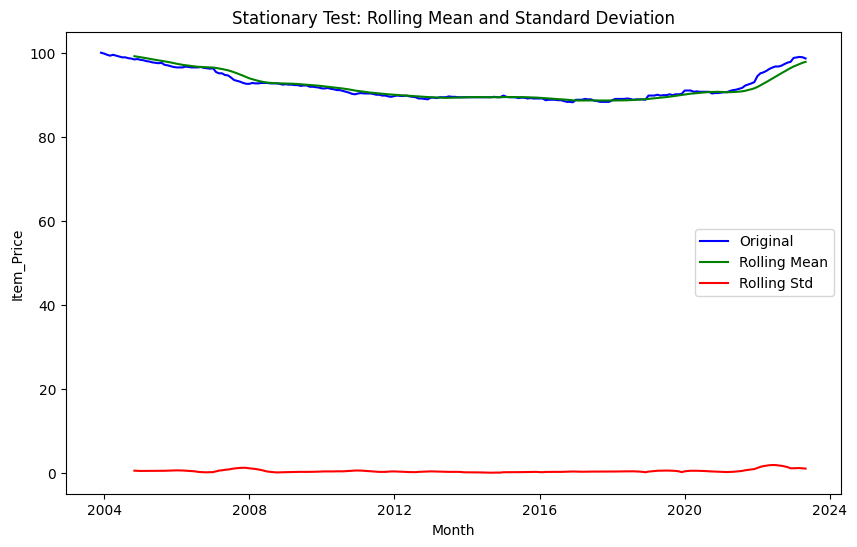

Results of Dickey-Fuller Test
Test Statistic                  -1.620904
p-value                          0.472255
#Lags Used                      15.000000
Number of Observations Used    218.000000
Critical Value (1%)             -3.460708
Critical Value (5%)             -2.874891
Critical Value (10%)            -2.573886
dtype: float64


In [28]:
stationarity_test(df_new['Price'])

### Differencing

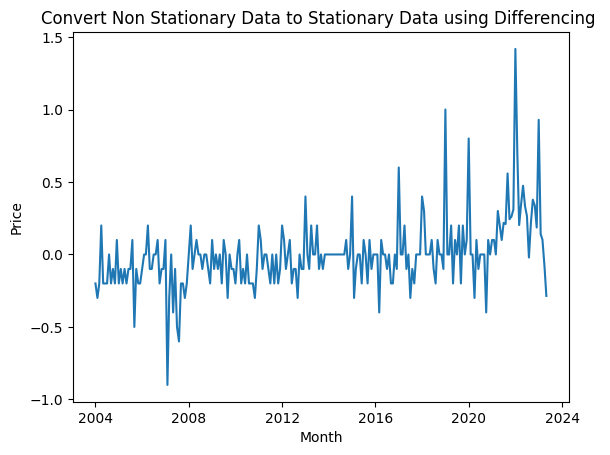

In [29]:
df_diff = df_new['Price'].diff(periods = 1) # First order differencing
plt.xlabel('Month')
plt.ylabel('Price')    
plt.title('Convert Non Stationary Data to Stationary Data using Differencing ')
plt.plot(df_diff)

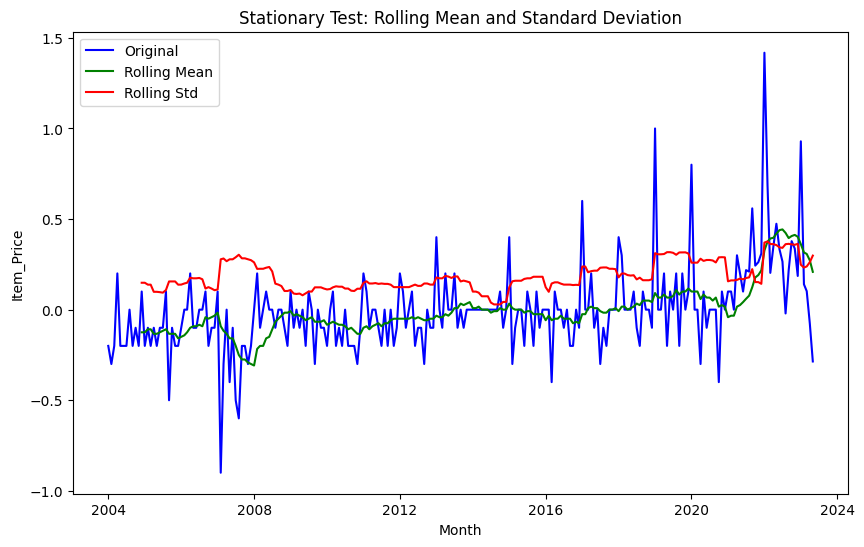

Results of Dickey-Fuller Test
Test Statistic                  -3.004331
p-value                          0.034492
#Lags Used                      15.000000
Number of Observations Used    217.000000
Critical Value (1%)             -3.460849
Critical Value (5%)             -2.874953
Critical Value (10%)            -2.573919
dtype: float64


In [30]:
df_diff.dropna(inplace = True)# Data transformation may add na values
stationarity_test(df_diff)

### Transformation

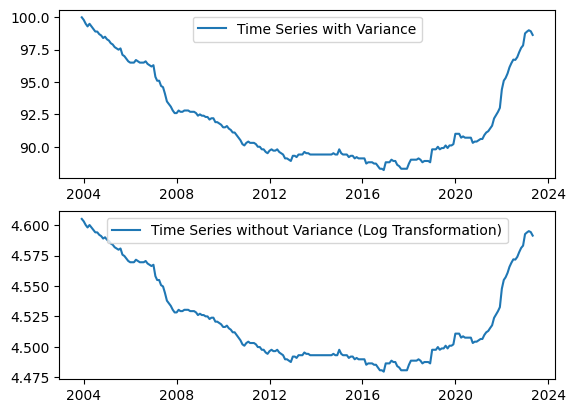

In [31]:
df_log = np.log(df_new['Price'])

plt.subplot(211)
plt.plot(df_new['Price'], label= 'Time Series with Variance')
plt.legend()
plt.subplot(212)
plt.plot(df_log, label='Time Series without Variance (Log Transformation)')
plt.legend()  
plt.show()

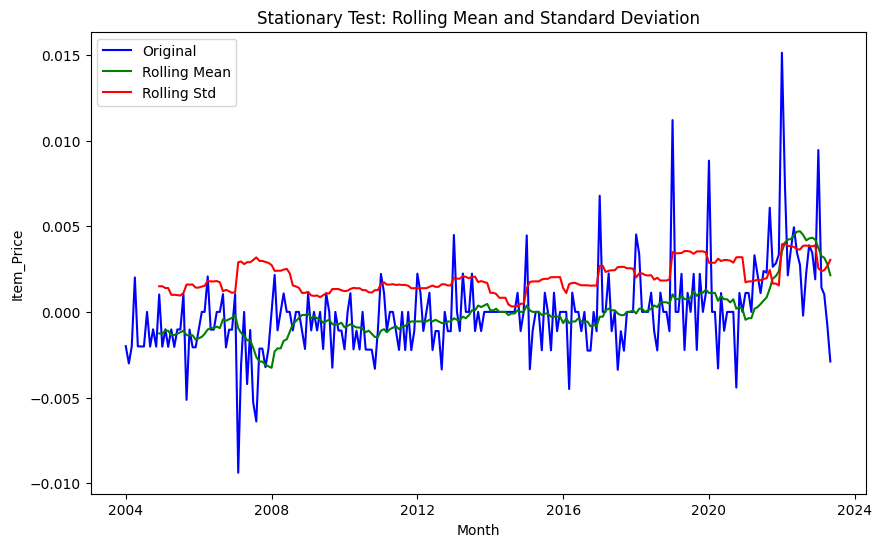

Results of Dickey-Fuller Test
Test Statistic                  -3.001129
p-value                          0.034789
#Lags Used                      15.000000
Number of Observations Used    217.000000
Critical Value (1%)             -3.460849
Critical Value (5%)             -2.874953
Critical Value (10%)            -2.573919
dtype: float64


In [32]:
df_log_diff = df_log.diff(periods = 1) # First order differencing

df_log_diff.dropna(inplace = True)# Data transformation may add na values

stationarity_test(df_log_diff)

In [33]:
df_new= df_new.drop(['12-month-SMA','EWMA12'],axis=1)

In [34]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 234 entries, 2003-12-01 to 2023-05-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   234 non-null    float64
dtypes: float64(1)
memory usage: 11.8 KB


In [35]:
# df_new['Price'].plot(figsize=(10,5))

## Forecasting with the Holt-Winters Method

### Train Test Split

In [36]:
train_data = df_new.iloc[:222] # Goes up to but not including 101
test_data = df_new.iloc[222:]

### Fitting the Model

In [37]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

fitted_model = ExponentialSmoothing(train_data['Price'],trend='mul',seasonal='mul',seasonal_periods=12).fit()

C:\Users\msalehi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


### Evaluating Model against Test Set

In [38]:
test_predictions = fitted_model.forecast(12).rename('HW Forecast')

In [39]:
test_predictions

2022-06-01     96.561306
2022-07-01     96.981325
2022-08-01     97.417259
2022-09-01     97.802804
2022-10-01     98.197026
2022-11-01     98.644242
2022-12-01     99.105576
2023-01-01    100.033833
2023-02-01    100.391087
2023-03-01    100.697693
2023-04-01    101.231254
2023-05-01    101.741848
Freq: MS, Name: HW Forecast, dtype: float64

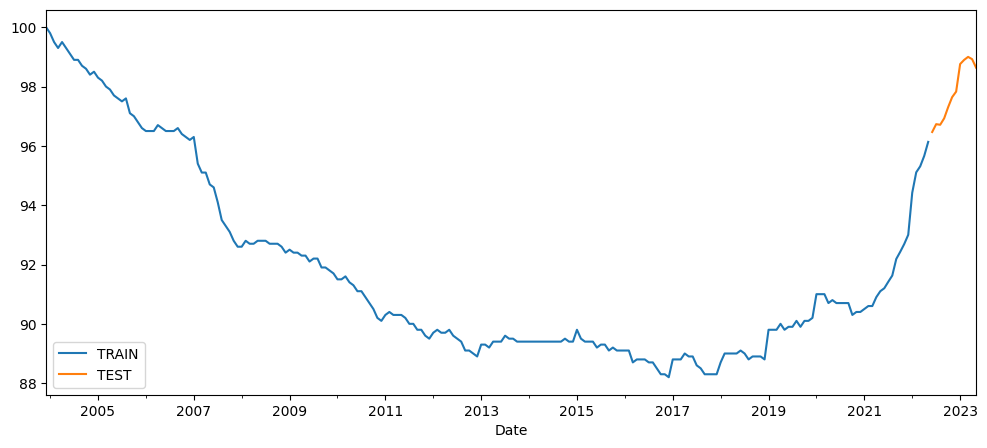

In [40]:
train_data['Price'].plot(legend=True,label='TRAIN')
test_data['Price'].plot(legend=True,label='TEST',figsize=(12,5));

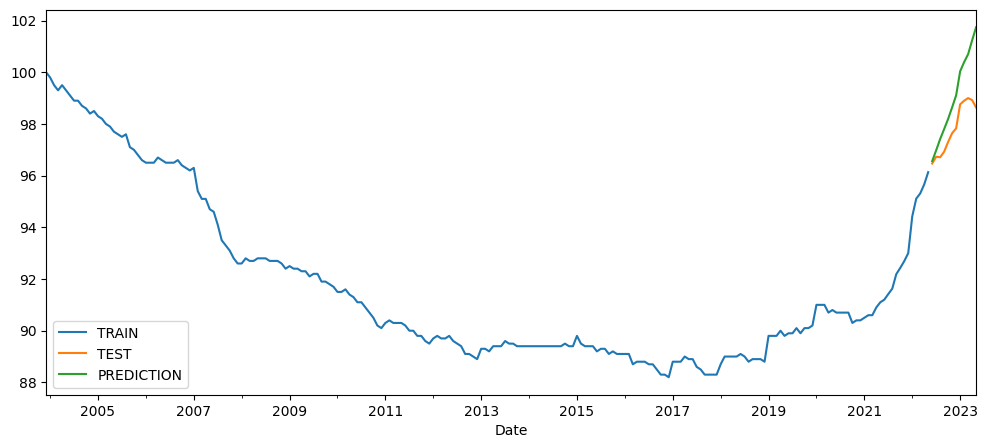

In [41]:
train_data['Price'].plot(legend=True,label='TRAIN')
test_data['Price'].plot(legend=True,label='TEST',figsize=(12,5))
test_predictions.plot(legend=True,label='PREDICTION');

In [42]:
final_model = ExponentialSmoothing(df_new['Price'],trend='mul',seasonal='mul',seasonal_periods=12).fit()

In [43]:
forecast_predictions = final_model.forecast(12)

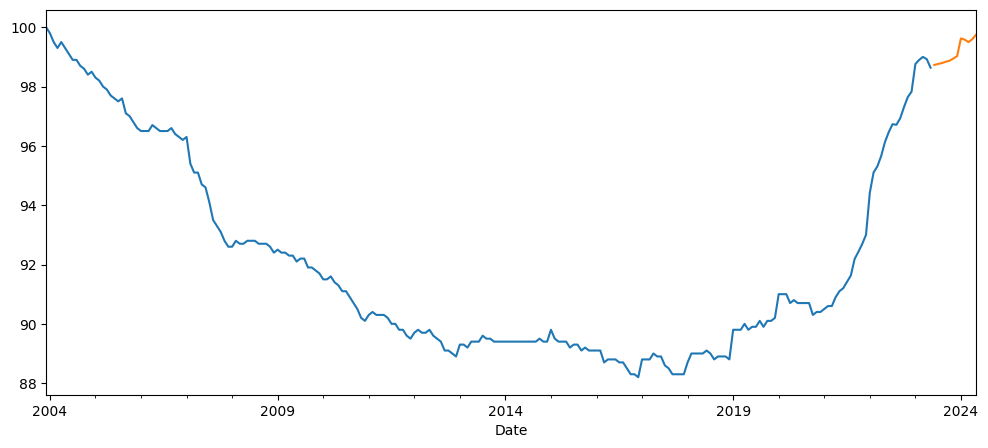

In [44]:
df_new['Price'].plot(figsize=(12,5))
forecast_predictions.plot();

### Evaluation Metrics

In [45]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [46]:
mean_absolute_error(test_data,test_predictions)

1.2477711445922222

In [47]:
mean_squared_error(test_data,test_predictions)

2.2057116791699056

In [48]:
np.sqrt(mean_squared_error(test_data,test_predictions))

1.485163856000376

In [49]:
df_new['Price'].describe()

count    234.000000
mean      92.049239
std        3.394654
min       88.200000
25%       89.400000
50%       90.650000
75%       94.555000
max      100.000000
Name: Price, dtype: float64

## AR(p)
### Autoregressive Model

## Lagging
Also known as "backshifting", lagging notation reflects the value of $y$ at a prior point in time. This is a useful technique for performing <em>regressions</em> as we'll see in upcoming sections.

\begin{split}L{y_t} = y_{t-1} & \text{      one lag shifts the data back one period}\\
L^{2}{y_t} = y_{t-2} & \text{      two lags shift the data back two periods} \end{split}
<br><br>
<table>
<tr><td>$y_t$</td><td>6</td><td>8</td><td>3</td><td>4</td><td>9</td><td>2</td><td>5</td></tr>
<tr><td>$y_{t-1}$</td><td>8</td><td>3</td><td>4</td><td>9</td><td>2</td><td>5</td></tr>
<tr><td>$y_{t-2}$</td><td>3</td><td>4</td><td>9</td><td>2</td><td>5</td></tr>
</table>


In [50]:
# Load specific forecasting tools
from statsmodels.tsa.ar_model import AR,ARResults

In [51]:
from statsmodels.tsa.ar_model import AutoReg

In [52]:
df_new.head()

,Price
Date,
2003-12-01,100.0
2004-01-01,99.8
2004-02-01,99.5
2004-03-01,99.3
2004-04-01,99.5


In [53]:
# Set one year for testing
train = df_new.iloc[:112]
test = df_new.iloc[112:]

### Fit an AR(1) Model

In [54]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [55]:
model = AutoReg(train['Price'], lags=1)
AR1fit = model.fit()
print(f'Coefficients:\n{AR1fit.params}')

Coefficients:
const       0.890870
Price.L1    0.989443
dtype: float64


In [56]:
# This is the general format for obtaining predictions
start=len(train)
end=len(train)+len(test)-1
predictions1 = AR1fit.predict(start=start, end=end, dynamic=False).rename('AR(1) Predictions')

In [57]:
predictions1

2013-04-01    89.149146
2013-05-01    89.098829
2013-06-01    89.049043
2013-07-01    88.999782
2013-08-01    88.951042
                ...    
2023-01-01    85.759862
2023-02-01    85.745327
2023-03-01    85.730945
2023-04-01    85.716715
2023-05-01    85.702636
Freq: MS, Name: AR(1) Predictions, Length: 122, dtype: float64

<Axes: xlabel='Date'>

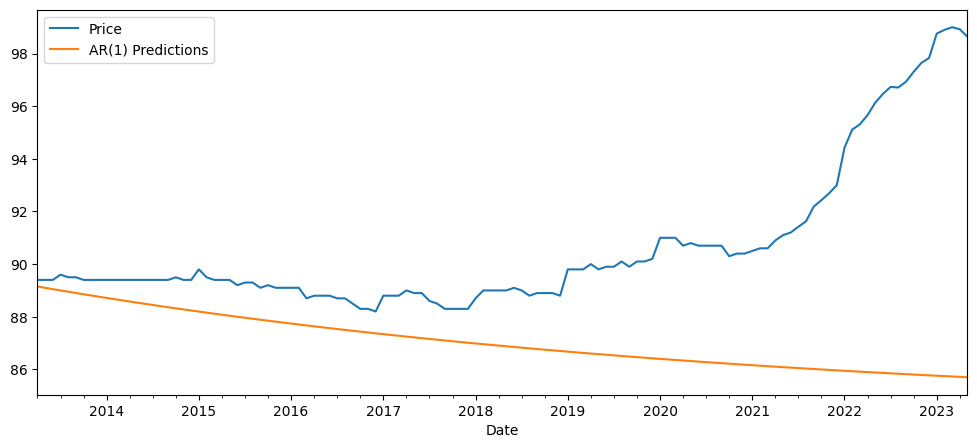

In [58]:
test.plot(figsize=(12,5), legend=True)
predictions1.plot(legend=True)

### Fit an AR(2) Model

In [59]:
model = AutoReg(train['Price'], lags=2)
AR2fit = model.fit()
print(f'Coefficients:\n{AR2fit.params}')

Coefficients:
const       0.828602
Price.L1    1.056630
Price.L2   -0.066449
dtype: float64


In [60]:
predictions2 = AR2fit.predict(start=start, end=end, dynamic=False).rename('AR(2) Predictions')

<Axes: xlabel='Date'>

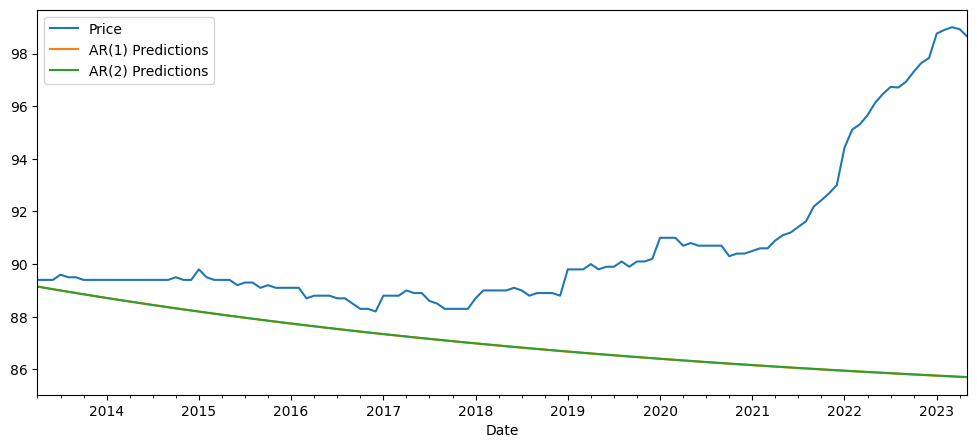

In [61]:
test.plot(figsize=(12,5), legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True)

### Fit an AR(p) model where statsmodels chooses p

In [62]:
# Define a range of lags to consider
lags_range = range(1, 10)

# Initialize variables for best AIC and best lag
best_aic = float("inf")
best_lag = None

# Iterate over the lags and fit AutoReg models
for lag in lags_range:
    model = AutoReg(train['Price'], lags=lag)
    fit = model.fit()
    
    # Check if the current model has lower AIC
    if fit.aic < best_aic:
        best_aic = fit.aic
        best_lag = lag

# Fit the AutoReg model with the best lag
best_model = AutoReg(train['Price'], lags=best_lag)
best_fit = best_model.fit()
print(f'Lag: {best_lag}')
print(f'Coefficients:\n{best_fit.params}')

Lag: 1
Coefficients:
const       0.890870
Price.L1    0.989443
dtype: float64


In [63]:
model = AutoReg(train['Price'], lags=1)
AR1fit = model.fit()
print(f'Coefficients:\n{AR1fit.params}')

Coefficients:
const       0.890870
Price.L1    0.989443
dtype: float64


In [64]:
predictions1 = AR1fit.predict(start=start, end=end, dynamic=False).rename('AR(1) Predictions')

<Axes: xlabel='Date'>

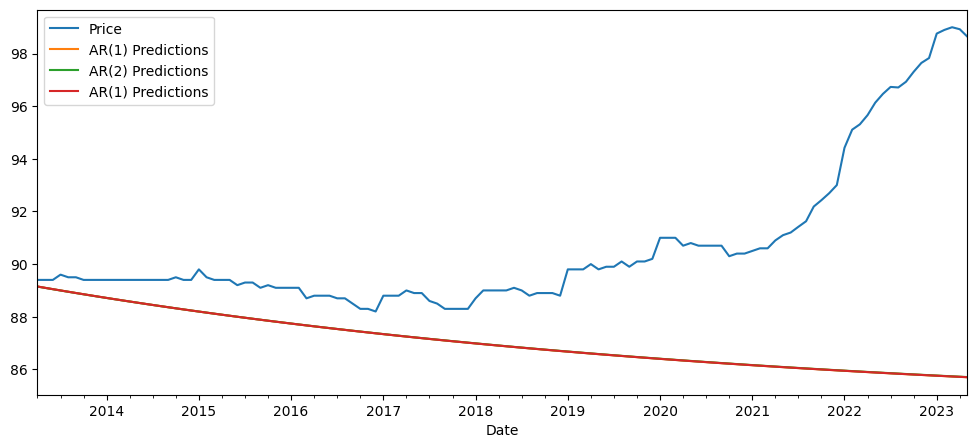

In [65]:
test.plot(figsize=(12,5), legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True)
predictions1.plot(legend=True)

### Evaluate the Model
It helps to have a means of comparison between two or more models. One common method is to compute the Mean Squared Error (MSE), available from scikit-learn

In [66]:
from sklearn.metrics import mean_squared_error

labels = ['AR(1)','AR(2)','AR(1)']
preds = [predictions1, predictions2, predictions1]  # these are variables, not strings!

for i in range(3):
    error = mean_squared_error(test['Price'], preds[i])
    print(f'{labels[i]} Error: {error:11.10}')

AR(1) Error: 25.11480401
AR(2) Error: 25.07963696
AR(1) Error: 25.11480401


In [67]:
np.sqrt(mean_squared_error(test['Price'],predictions1))

5.011467251565904

Another method is the Akaike information criterion (AIC), which does a better job of evaluating models by avoiding overfitting.
Fortunately this is available directly from the fit model object.

In [68]:
modls = [AR1fit,AR2fit,AR1fit]

for i in range(3):
    print(f'{labels[i]} AIC: {modls[i].aic:6.5}')

AR(1) AIC: -77.154
AR(2) AIC: -73.952
AR(1) AIC: -77.154


### Forecasting
Now we're ready to train our best model on the greatest amount of data, and fit it to future dates.

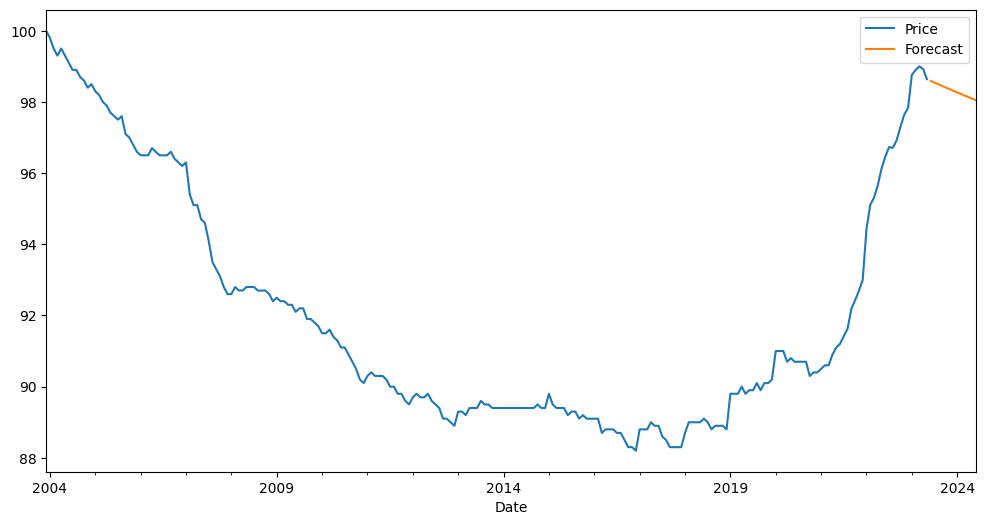

In [69]:
# First, retrain the model on the full dataset
model = AutoReg(df_new['Price'], lags=1)

# Next, fit the model
AR1fit = model.fit()

# Make predictions
fcast = AR1fit.predict(start=len(df_new), end=len(df_new)+12, dynamic=False).rename('Forecast')

# Plot the results
df_new['Price'].plot(legend=True)
fcast.plot(legend=True,figsize=(12,6));

## pmdarima Auto-ARIMA

In [70]:
from pmdarima import auto_arima

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [71]:
auto_arima(df_new['Price'],seasonal=False)

ARIMA(order=(1, 2, 1), scoring_args={}, suppress_warnings=True)

In [72]:
auto_arima(df_new['Price'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  234
Model:               SARIMAX(1, 2, 1)   Log Likelihood                  30.085
Date:                Thu, 22 Jun 2023   AIC                            -52.170
Time:                        13:12:51   BIC                            -38.383
Sample:                    12-01-2003   HQIC                           -46.610
                         - 05-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0015      0.001      2.461      0.014       0.000       0.003
ar.L1          0.1096      0.066      1.666      0.096      -0.019       0.239
ma.L1         -0.9663      0.018    -54.331      0.000      -1.001      -0.931
sigma2         0.0447      0.002     21.057      0.000       0.041       0.049
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               714.30
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               2.55   Skew:                             1.32
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Run the augmented Dickey-Fuller Test on the original data

In [73]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [74]:
adf_test(df_new['Price'],'Price')

Augmented Dickey-Fuller Test: Price
ADF test statistic       -1.620904
p-value                   0.472255
# lags used              15.000000
# observations          218.000000
critical value (1%)      -3.460708
critical value (5%)      -2.874891
critical value (10%)     -2.573886
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


### Run the augmented Dickey-Fuller Test on the First and Second Difference

In [75]:
from statsmodels.tsa.statespace.tools import diff
df_new['d1'] = diff(df_new['Price'],k_diff=1)

# Equivalent to:
# df1['d1'] = df1['Inventories'] - df1['Inventories'].shift(1)

adf_test(df_new['d1'],'Price')

Augmented Dickey-Fuller Test: Price
ADF test statistic       -3.004331
p-value                   0.034492
# lags used              15.000000
# observations          217.000000
critical value (1%)      -3.460849
critical value (5%)      -2.874953
critical value (10%)     -2.573919
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [76]:
from statsmodels.tsa.statespace.tools import diff
df_new['d2'] = diff(df_new['Price'],k_diff=2)

# Equivalent to:
# df1['d1'] = df1['Inventories'] - df1['Inventories'].shift(1)

adf_test(df_new['d2'],'Price')

Augmented Dickey-Fuller Test: Price
ADF test statistic       -4.289541
p-value                   0.000463
# lags used              13.000000
# observations          218.000000
critical value (1%)      -3.460708
critical value (5%)      -2.874891
critical value (10%)     -2.573886
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


### Run the ACF and PACF plots
This confirms that we reached stationarity after the first difference.
A <strong>PACF Plot</strong> can reveal recommended AR(p) orders, and an <strong>ACF Plot</strong> can do the same for MA(q) orders.<br>

In [77]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

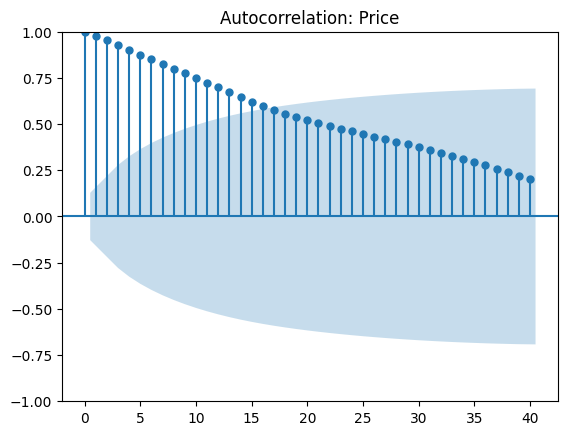

In [78]:
title = 'Autocorrelation: Price'
lags = 40
plot_acf(df_new['Price'],title=title,lags=lags);

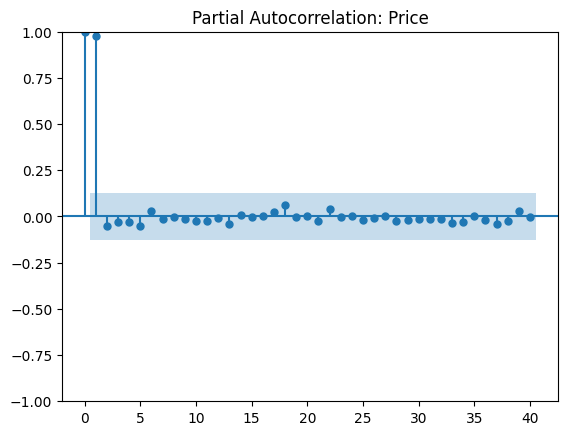

In [79]:
title = 'Partial Autocorrelation: Price'
lags = 40
plot_pacf(df_new['Price'],title=title,lags=lags);

This tells us that the AR component should be more important than MA. From the <a href='https://people.duke.edu/~rnau/411arim3.htm'>Duke University Statistical Forecasting site</a>:<br>
> <em>If the PACF displays a sharp cutoff while the ACF decays more slowly (i.e., has significant spikes at higher lags), we    say that the stationarized series displays an "AR signature," meaning that the autocorrelation pattern can be explained more    easily by adding AR terms than by adding MA terms.</em><br>

### ARIMA Model

In [80]:
# Set one year for testing
train = df_new.iloc[:222]
test = df_new.iloc[222:]

In [81]:
# Load specific forecasting tools

from statsmodels.tsa.arima.model import ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders

In [82]:
model = ARIMA(train['Price'],order=(1,2,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  222
Model:                 ARIMA(1, 2, 1)   Log Likelihood                  34.046
Date:                Thu, 22 Jun 2023   AIC                            -62.092
Time:                        13:12:52   BIC                            -51.911
Sample:                    12-01-2003   HQIC                           -57.981
                         - 05-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0153      0.099     -0.154      0.878      -0.210       0.180
ma.L1         -0.8482      0.048    -17.735      0.000      -0.942      -0.754
sigma2         0.0427      0.002     21.931      0.000       0.039       0.047
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               690.30
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               2.21   Skew:                             1.30
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [83]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end).rename('ARIMA(1,2,1) Predictions')

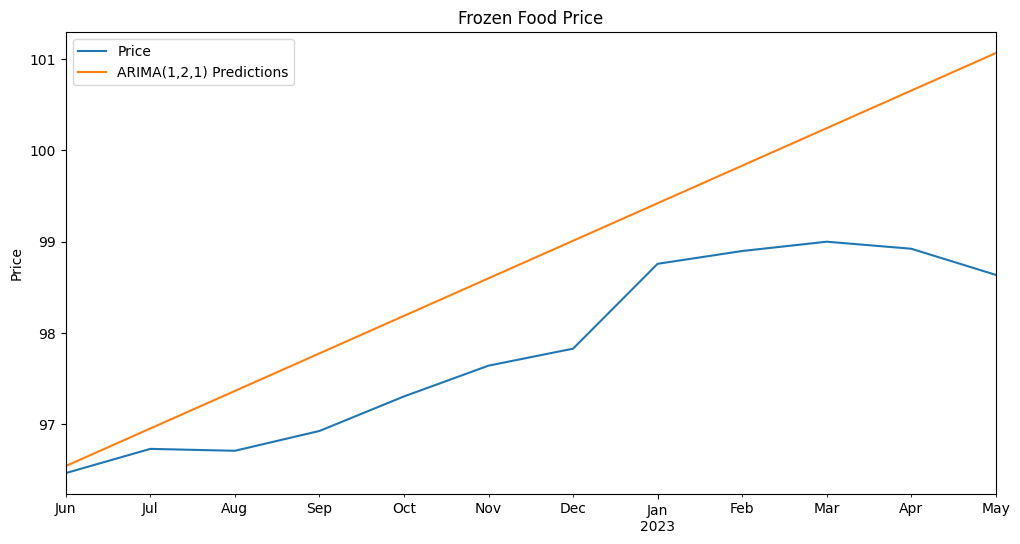

In [84]:
title = 'Frozen Food Price'
ylabel='Price'
xlabel='' # we don't really need a label here

ax = test['Price'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [85]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(1,2,1) Predictions')

Passing dynamic=False means that forecasts at each point are generated using the full history up to that point (all lagged values).

Passing typ='levels' predicts the levels of the original endogenous variables. If we'd used the default typ='linear' we would have seen linear predictions in terms of the differenced endogenous variables.

https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.predict.html

In [86]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['Price'][i]}")

predicted=96.54402793, expected=96.467
predicted=96.95503369, expected=96.732
predicted=97.3660245 , expected=96.711
predicted=97.77701554, expected=96.928
predicted=98.18800658, expected=97.306
predicted=98.59899761, expected=97.643
predicted=99.00998865, expected=97.829
predicted=99.42097969, expected=98.758
predicted=99.83197073, expected=98.898
predicted=100.2429618, expected=99.0
predicted=100.6539528, expected=98.923
predicted=101.0649438, expected=98.637


In [87]:
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

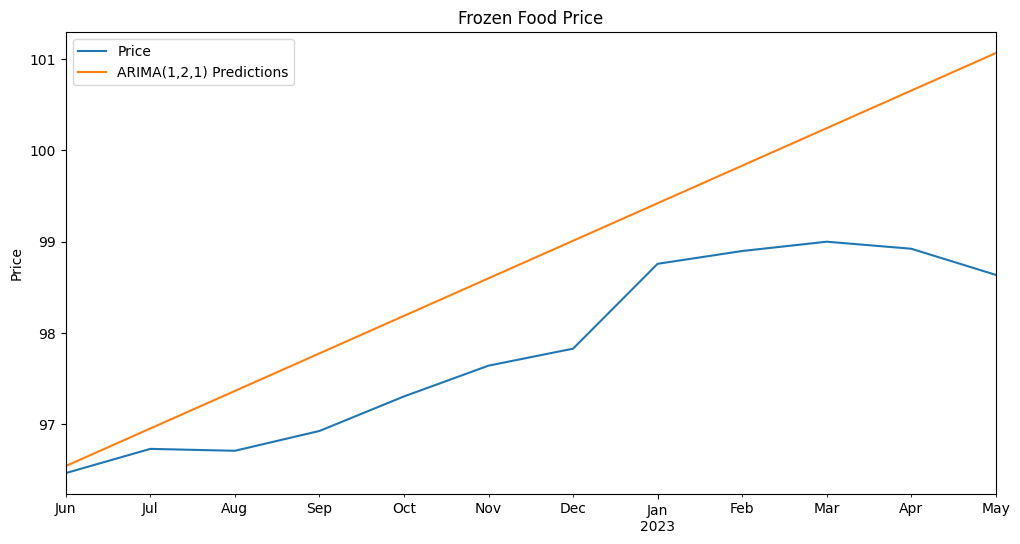

In [88]:
# Plot predictions against known values
title = 'Frozen Food Price'
ylabel='Price'
xlabel='' # we don't really need a label here

ax = test['Price'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

### Evaluate the Model

In [89]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['Price'], predictions)
print(f'ARIMA(1,2,1) MSE Error: {error:11.10}')

ARIMA(1,2,1) MSE Error: 1.336672436


In [90]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['Price'], predictions)
print(f'ARIMA(1,2,1) RMSE Error: {error:11.10}')

ARIMA(1,2,1) RMSE Error: 1.156145508


In [91]:
df_new['Price'].mean()

92.04923931623934

In [92]:
predictions.mean()

98.80449194214304

### Retrain the model on the full data, and forecast the future

In [93]:
model = ARIMA(df_new['Price'],order=(1,2,1))
results = model.fit()
fcast = results.predict(len(df_new),len(df_new)+11,typ='levels').rename('ARIMA(1,2,1) Forecast')

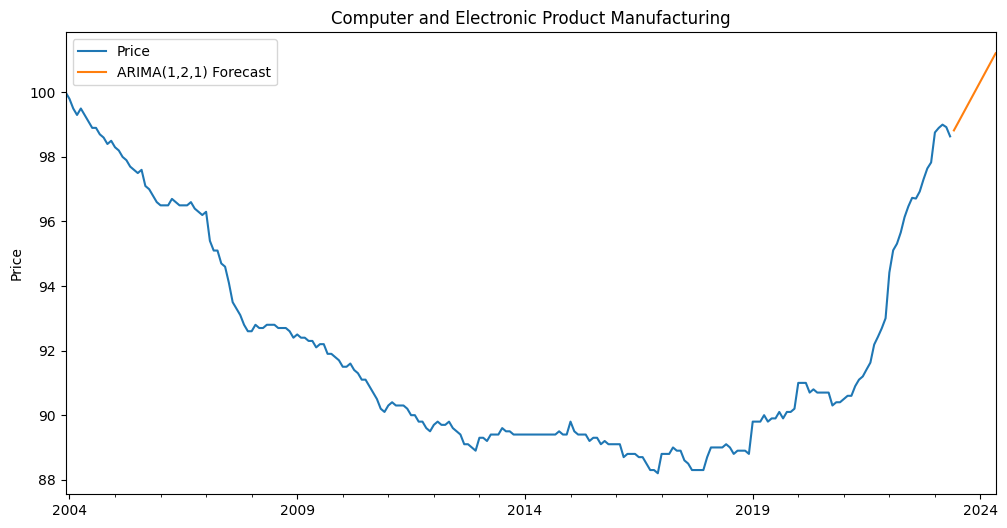

In [94]:
# Plot predictions against known values
title = 'Computer and Electronic Product Manufacturing'
ylabel='Price'
xlabel='' # we don't really need a label here

ax = df_new['Price'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

# SARIMA(p,d,q)(P,D,Q)m
# Seasonal Autoregressive Integrated Moving Averages

In [95]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [96]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(df_new['Price'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  234
Model:             SARIMAX(0, 2, 1)x(2, 0, [1, 2], 12)   Log Likelihood                  55.820
Date:                                 Thu, 22 Jun 2023   AIC                            -99.641
Time:                                         13:13:12   BIC                            -78.960
Sample:                                     12-01-2003   HQIC                           -91.300
                                          - 05-01-2023                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8218      0.040    -20.353      0.000      -0.901      -0.743
ar.S.L12       1.3415      0.287      4.675      0.000       0.779       1.904
ar.S.L24      -0.3843      0.291     -1.321      0.187      -0.954       0.186
ma.S.L12      -1.3529      0.274     -4.941      0.000      -1.890      -0.816
ma.S.L24       0.5446      0.249      2.186      0.029       0.056       1.033
sigma2         0.0343      0.002     14.289      0.000       0.030       0.039
===================================================================================
Ljung-Box (L1) (Q):                   0.40   Jarque-Bera (JB):                98.98
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):               1.60   Skew:                            -0.02
Prob(H) (two-sided):                  0.04   Kurtosis:                         6.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [97]:
model = SARIMAX(train['Price'],order=(0,2,1),seasonal_order=(2, 0, [1, 2], 12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                   Price   No. Observations:                  222
Model:             SARIMAX(0, 2, 1)x(2, 0, [1, 2], 12)   Log Likelihood                  56.592
Date:                                 Thu, 22 Jun 2023   AIC                           -101.184
Time:                                         13:13:13   BIC                            -80.822
Sample:                                     12-01-2003   HQIC                           -92.961
                                          - 05-01-2022                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8325      0.040    -20.939      0.000      -0.910      -0.755
ar.S.L12       1.1451      0.445      2.571      0.010       0.272       2.018
ar.S.L24      -0.2003      0.444     -0.451      0.652      -1.071       0.670
ma.S.L12      -1.1388      0.430     -2.650      0.008      -1.981      -0.297
ma.S.L24       0.3658      0.380      0.964      0.335      -0.378       1.110
sigma2         0.0335      0.002     14.389      0.000       0.029       0.038
===================================================================================
Ljung-Box (L1) (Q):                   0.92   Jarque-Bera (JB):               129.31
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               1.46   Skew:                             0.06
Prob(H) (two-sided):                  0.11   Kurtosis:                         6.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [98]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA order=(0,2,1),seasonal_order=(2, 0, [1, 2], 12) Predictions')

In [99]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['Price'][i]}")

predicted=96.53826103, expected=96.467
predicted=96.88147272, expected=96.732
predicted=97.27127917, expected=96.711
predicted=97.60270892, expected=96.928
predicted=97.95785465, expected=97.306
predicted=98.36486121, expected=97.643
predicted=98.75654791, expected=97.829
predicted=99.57761876, expected=98.758
predicted=100.0187904, expected=98.898
predicted=100.3963715, expected=99.0
predicted=100.8327903, expected=98.923
predicted=101.2434029, expected=98.637


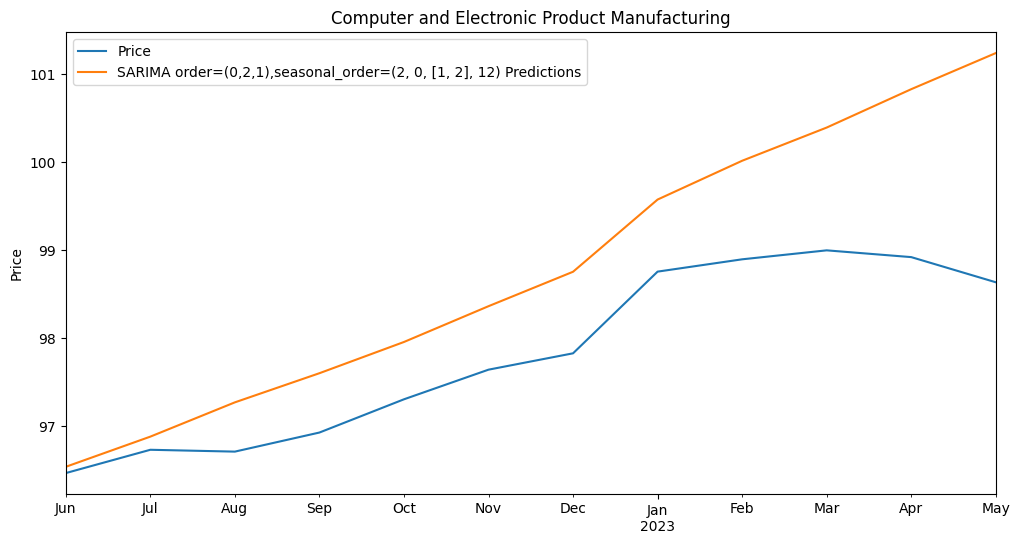

In [100]:
# Plot predictions against known values
title = 'Computer and Electronic Product Manufacturing'
ylabel='Price'
xlabel=''

ax = test['Price'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [101]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['Price'], predictions)
print(f'SARIMA order=(0,2,1),seasonal_order=(2, 0, [1, 2], 12) MSE Error: {error:11.10}')

SARIMA order=(0,2,1),seasonal_order=(2, 0, [1, 2], 12) MSE Error: 1.410111914


In [102]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['Price'], predictions)
print(f'SARIMA order=(0,2,1),seasonal_order=(2, 0, [1, 2], 12) RMSE Error: {error:11.10}')

SARIMA order=(0,2,1),seasonal_order=(2, 0, [1, 2], 12) RMSE Error: 1.187481332


In [103]:
model = SARIMAX(df_new['Price'],order=(0,2,1),seasonal_order=(2, 0, [1, 2], 12))
results = model.fit()
fcast = results.predict(len(df_new),len(df_new)+11,typ='levels').rename('SARIMA order=(0,2,1),seasonal_order=(2, 0, [1, 2], 12) Forecast')

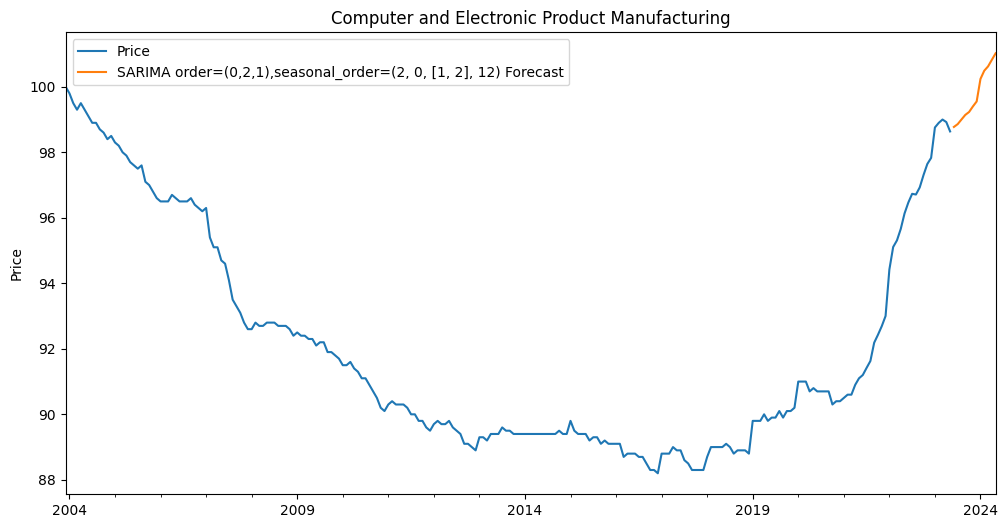

In [104]:
# Plot predictions against known values
title = 'Computer and Electronic Product Manufacturing'
ylabel='Price'
xlabel=''

ax = df_new['Price'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);